# ページごとの閲覧数を取得

In [1]:
import json
import pickle
from collections import defaultdict

import requests
from tqdm.notebook import tqdm
import pandas as pd

In [2]:
def get_daily_views(page_name, start_date="20201201", end_date="20211130"):
    page_name = page_name.replace("/", "%2F")

    endpoint = "https://wikimedia.org/api/rest_v1"\
                        "/metrics/pageviews/per-article/ja.wikipedia.org/all-access/all-agents" \
                        f"/{page_name}/daily/{start_date}/{end_date}"

    res = requests.get(endpoint, headers={"User-Agent": "s@89.io"})
    res.raise_for_status()

    daily_views = {}
    for item in res.json()["items"]:
        date = item["timestamp"][:8]
        views = item["views"]
        daily_views[date] = views
    
    return daily_views

In [3]:
get_daily_views("大谷翔平", start_date="20211101", end_date="20211107")

{'20211101': 7533,
 '20211102': 6206,
 '20211103': 5481,
 '20211104': 6356,
 '20211105': 6461,
 '20211106': 6822,
 '20211107': 5358}

In [4]:
# アクセス数がゼロの日は含まれない
get_daily_views("中森三弥", start_date="20211101", end_date="20211107")

{'20211103': 1, '20211106': 1}

---

In [5]:
with open("../data/workspace/page_locations_clean.json") as fp:
    page_locations_clean = json.load(fp)
len(page_locations_clean)

16528

In [6]:
with open("../data/workspace/page_views.pickle", "rb") as fp:
    page_views = pickle.load(fp)

In [7]:
for page, locations in tqdm(page_locations_clean.items()):
    if page in page_views:
        continue
    page_views[page] = get_daily_views(page)

  0%|          | 0/16528 [00:00<?, ?it/s]

In [8]:
len(page_views)

16528

In [9]:
# JSONではファイルサイズが100MB以上と大きくなるため、pickleでシリアライズ
# GitHubレポジトリへアップロードするため（100MB制限）
with open("../data/workspace/page_views.pickle", "wb") as fp:
    pickle.dump(page_views, fp)

## 確認: アクセス日数

In [10]:
df_count = pd.DataFrame([(k, len(v)) for k, v in page_views.items()], columns=["ページ", "view日数"]).sort_values("view日数")
df_count

,ページ,view日数
5262,天野将平,79
4809,大井成元_(サッカー),96
11159,清水達也_(野球),99
1603,中島愛_(声優),170
1810,中森三弥,170
...,...,...
6091,小林浩美,365
6092,小林涼,365
6094,小林珠維,365
6096,小林直己,365


### 「アクセスのない日」が存在するケース

- 誰もアクセスしなかった
- そのときにまだページが存在しなかった
- そのページがのちに削除された、移動（リネーム）された

In [11]:
df_count.query("view日数 < 365")

,ページ,view日数
5262,天野将平,79
4809,大井成元_(サッカー),96
11159,清水達也_(野球),99
1603,中島愛_(声優),170
1810,中森三弥,170
...,...,...
5838,小倉順平,364
2418,仲摩純平,364
1740,中村昌秀,364
11891,田向泰輝,364


In [12]:
print(
    "「アクセスのない日」が存在するページ: 全体の" +  \
    f"""{df_count.query("view日数 < 365").shape[0] / df_count.shape[0]:.1%}"""
)

「アクセスのない日」が存在するページ: 全体の20.4%


In [13]:
df_count.groupby("view日数").count()\
    .reset_index().rename(columns={"ページ": "該当ページ数"})\
    .sort_values("該当ページ数", ascending=False)

,view日数,該当ページ数
135,365,13154
134,364,626
133,363,334
132,362,220
131,361,186
...,...,...
30,256,1
29,255,1
26,252,1
24,250,1


## 確認: view数

In [14]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [15]:
def get_location(page):
    locs = page_locations_clean[page]
    return ",".join([p+k for p, k in locs])

In [16]:
data = []
index = []
for page, views in page_views.items():
    location = get_location(page)
    for date, view in views.items():
        index.append(date)
        data.append( (page, location, view) )

df_views = pd.DataFrame(data, index, columns=["page", "location", "view"])
df_views.index = pd.to_datetime(df_views.index)
df_views

,page,location,view
2020-12-01,%22brother%22YASSHI,京都府宇治市,28
2020-12-02,%22brother%22YASSHI,京都府宇治市,49
2020-12-03,%22brother%22YASSHI,京都府宇治市,35
2020-12-04,%22brother%22YASSHI,京都府宇治市,33
2020-12-05,%22brother%22YASSHI,京都府宇治市,44
...,...,...,...
2021-11-26,［Alexandros］,愛知県日進市,757
2021-11-27,［Alexandros］,愛知県日進市,894
2021-11-28,［Alexandros］,愛知県日進市,1147
2021-11-29,［Alexandros］,愛知県日進市,1067


### 日別

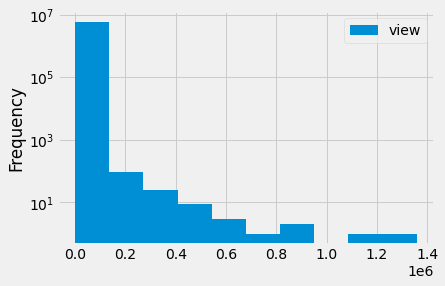

In [17]:
df_views[["view"]].plot.hist(log=True);

In [18]:
df_views.sort_values("view", ascending=False).head(10)

,page,location,view
2021-05-18,田村正和,東京都世田谷区,1358099
2021-09-29,岸田文雄,東京都渋谷区,1106389
2021-08-19,千葉真一,福岡県福岡市博多区,931849
2021-04-02,夏目三久,大阪府箕面市,893724
2021-05-19,新垣結衣,沖縄県那覇市,782043
2021-05-19,星野源,埼玉県川口市,677074
2021-05-19,田村正和,東京都世田谷区,667718
2021-05-18,田村亮_(俳優),東京都世田谷区,552697
2021-04-03,夏目三久,大阪府箕面市,541181
2020-12-28,今井ゆうぞう,徳島県三好市,530280


cf. [Life After Death on Wikipedia](https://pudding.cool/2018/08/wiki-death/)

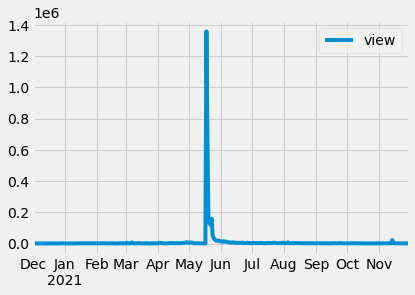

In [19]:
df_views[df_views["page"] == "田村正和"].plot();

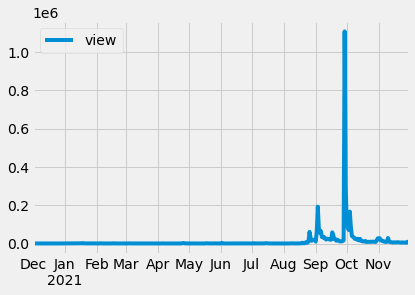

In [20]:
df_views[df_views["page"] == "岸田文雄"].plot();

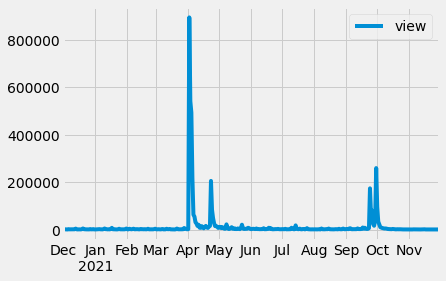

In [21]:
df_views[df_views["page"] == "夏目三久"].plot();

### 年間合計

In [22]:
df_views_yearly = df_views.groupby("page").sum().reset_index()
df_views_yearly["location"] = df_views_yearly["page"].apply(get_location)
df_views_yearly

,page,view,location
0,%22brother%22YASSHI,20096,京都府宇治市
1,%22黒天使%22沼澤邪鬼,11849,埼玉県本庄市
2,1、2の大心,1659,沖縄県糸満市
3,8utterfly,4993,福岡県福岡市中央区
4,9mm_Parabellum_Bullet,110854,"山形県鶴岡市,茨城県北茨城市,長野県上伊那郡辰野町"
...,...,...,...
16523,龍田直樹,148688,和歌山県岩出市
16524,龍真咲,90001,大阪府東大阪市
16525,龍虎勢朋,58508,東京都大田区
16526,﨑山龍男,55765,栃木県佐野市


In [23]:
df_views_yearly.sort_values("view", ascending=False).head(20)

,page,view,location
5175,大谷翔平,4914419,岩手県奥州市
4733,夏目三久,4533254,大阪府箕面市
7173,岸田文雄,3976875,東京都渋谷区
15253,鈴木達央,3784710,"千葉県市川市,愛知県岡崎市"
11940,田村正和,3736385,東京都世田谷区
1383,上白石萌音,3656069,鹿児島県鹿児島市
3671,千葉真一,3266199,福岡県福岡市博多区
189,LiSA,3076135,岐阜県関市
8134,新垣結衣,3043616,沖縄県那覇市
8302,星野源,2882319,埼玉県川口市


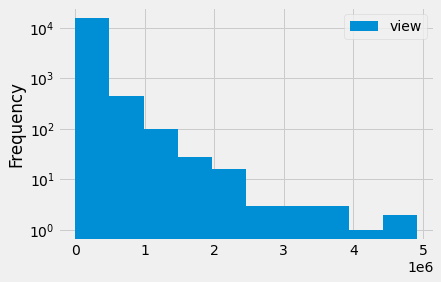

In [24]:
df_views_yearly.plot.hist(log=True);